# Equilibrado de Clases

### Target desbalanceado ("no equilibrado" o "desequilibrado")


Carguemos un dataset con un target desequilibrado y veamos las posibilidaes que tenemos (que no siempre mejorarán los resultados), importando nuestros módulos antes:

In [1]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
from imblearn.over_sampling import SMOTE # Nuevos amigos para ayudaros
from imblearn.under_sampling import RandomUnderSampler # Nuevos amigos para ayudarnos
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample


df = pd.read_csv("./data/bank_adapted.csv")
target = "y"

In [2]:
df[target].value_counts(normalize = True)

y
no     0.883931
yes    0.116069
Name: proportion, dtype: float64

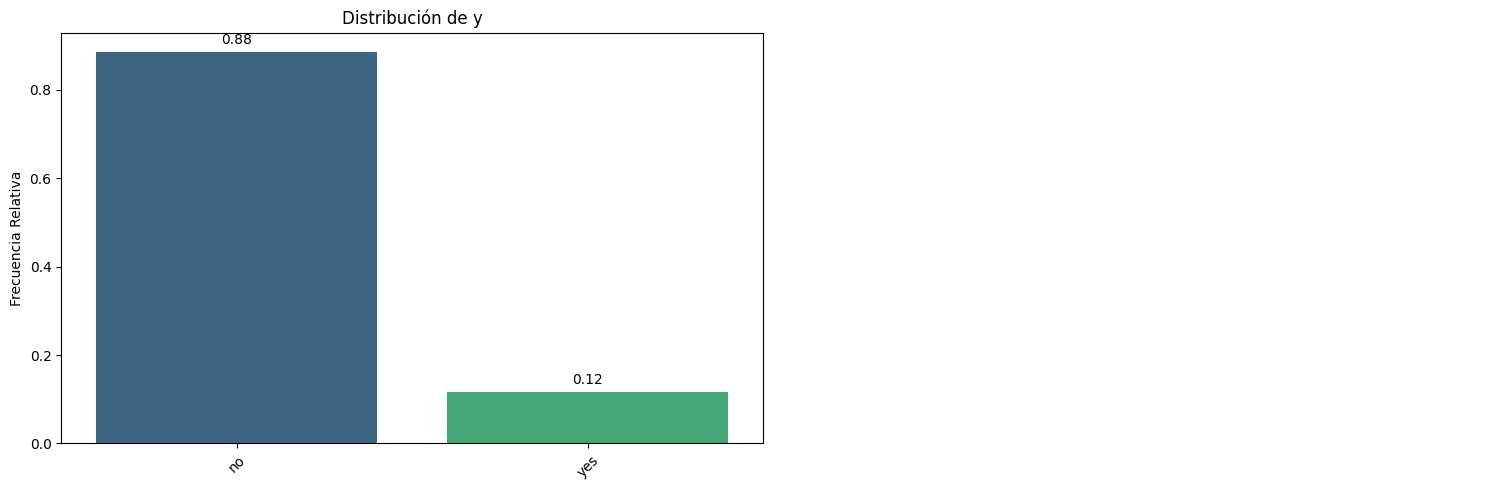

In [3]:
bt.pinta_distribucion_categoricas(df, [target], mostrar_valores= True, relativa= True)

Es un dataset claramente desequilibrado... ¿Qué podemos hacer?

### Comportamiento base (sin actuar)

In [4]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]
X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

In [5]:
lr_clf = LogisticRegression(max_iter = 10000)
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)

Veamos la evaluación contra test

In [6]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          no       0.92      0.97      0.95      6382
         yes       0.64      0.36      0.46       852

    accuracy                           0.90      7234
   macro avg       0.78      0.67      0.70      7234
weighted avg       0.89      0.90      0.89      7234



Claramente con los que no aceptan (recuerda que es un dataset de aceptar campañas) no lo hace nada mal (adivina el 98% de los que no van a aceptar, pero solo es capaz de "capturar" al 33% de los que sí)

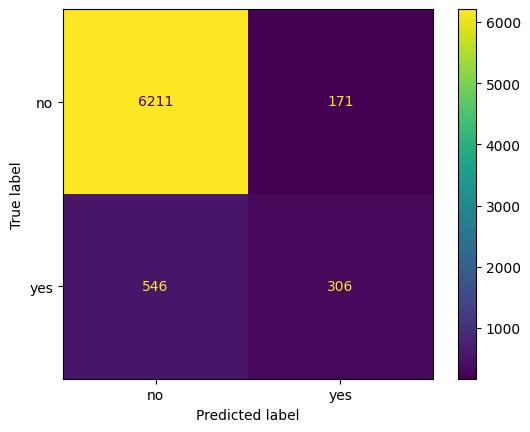

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

Intentemos "equilibrar" el dataset o tocar hiperparámetros para intentar "mejorar" (ya sabes que depende del problema de negocio) este resultado.


### Técnicas para Manejar el Desequilibrio


Tenemos tres formas genéricas (puede que en un problema en concreto podamos encontrar alguna otra forma de mejorar el impacto del desequilibrio) y un consejo práctico.

**0. Entender bien lo que persigué negocio.**

Sí, puede que no haya que tocar donde uno cree. En nuestro mismo ejemplo, en general, y en todas las campañas de marketing lo que querremos es que el recall de la clase positiva (aceptar o comprar lo que ofrezca la campaña) sea el más alto. Pero quizá lo que queramos, porque es una campaña con un alto coste de adquisición, es no hacersela a quien seguro que no va a decir que sí, o sea la precisión de la clase 0, en cuyo caso no necesitamos equilibra más, necesitaríamos quizá ser más selectivos con esa clase tocando la probabilidad umbral. 

Supongamos que es el recall o mejorar los números de la clase "minoritaria", entonces:

a. Sobremuestreo o Over-Sampling  
b. Bajomuestreo o Under-Sampling  
c. Modificación de pesos en la función de pérdida o de selección de ramas (el class-weight)


##### a. Sobremuestreo (Over-sampling) con SMOTE

Es decir crear muestras "sintéticas" de la clase minoritaria de forma que aumentememos la proporción de esta sin tocar la clase mayoritaria. Para ello se suele utilizar la técnica SMOTE.

SMOTE son las siglas de "Synthetic Minority Over-sampling Technique", que en español significa "Técnica de Sobremuestreo Sintético de Minorías". Es una técnica ampliamente utilizada en el campo del aprendizaje automático para abordar el problema de desequilibrio de clases en conjuntos de datos de clasificación.

Esto se hace seleccionando ejemplos de la clase minoritaria y creando nuevos ejemplos que son variaciones ligeras de los existentes, basándose en la combinación de varios ejemplos vecinos (sí vecinos como en el KNN)

Apliquemos SMOTE a nuestro problema:


In [8]:


# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Ahora las clases están totalmente equilibradas. Ojo, recuerda que por dentro usa un knn para crear las features de los sintéticos (y eso no tiene porque salir mejor).

In [9]:
y_train_smote.value_counts(True)

y
no     0.5
yes    0.5
Name: proportion, dtype: float64

In [10]:
X_train_smote.shape

(51176, 48)

In [11]:
X_train.shape

(28934, 48)

In [12]:

# Entrenar el modelo con los datos sobremuestreados
modelo_smote = LogisticRegression(random_state=42, max_iter = 25000)
modelo_smote.fit(X_train_smote, y_train_smote)

# Realizar predicciones y evaluar el modelo
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))


              precision    recall  f1-score   support

          no       0.95      0.92      0.93      6382
         yes       0.51      0.61      0.55       852

    accuracy                           0.88      7234
   macro avg       0.73      0.77      0.74      7234
weighted avg       0.89      0.88      0.89      7234



Hemos conseguido una mejora, ligera, que además deberíamos haber testado mejor con cross-validation, pero bueno menos es nada.

Otras técnicas de sobremuestreo:
1. Random Oversampling, se trata de repetir muestras de la clase minoritaria de manera aleatoria
2. ADASYN (Adaptive Synthetic (ADASYN) algorithm.), de la que puedes ver más información [aquí](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#imblearn.over_sampling.ADASYN)

**


##### b. Bajomuestreo (Under-sampling)

Igual que existe el sobremuestreo otra técnica es "quitar" del dataset de entrenamiento muestras de la clase mayoritaria (lo ideal sería de forma que afectase lo menos posible a esta, pero vamos a ver algo menos complejo). Utilizaremos `resample` de `sklearn`:

In [13]:
y_train

22201     no
1972      no
34913     no
30566     no
1523      no
        ... 
16850     no
6265      no
11284     no
860      yes
15795     no
Name: y, Length: 28934, dtype: object

In [14]:


# Separar las clases mayoritaria y minoritaria
clase_mayoritaria = X_train[y_train == "no"]
clase_minoritaria = X_train[y_train == "yes"]

# Bajomuestrear la clase mayoritaria
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])


In [15]:
y_train_bajomuestreo.value_counts(True)

y
no     0.5
yes    0.5
Name: proportion, dtype: float64

In [16]:

# Entrenar el modelo con los datos bajomuestreados
modelo_bajomuestreo = LogisticRegression(random_state=42, max_iter = 10000)
modelo_bajomuestreo.fit(X_train_bajomuestreo, y_train_bajomuestreo)

# Realizar predicciones y evaluar el modelo
y_pred_bajomuestreo = modelo_bajomuestreo.predict(X_test)
print(classification_report(y_test, y_pred_bajomuestreo))


              precision    recall  f1-score   support

          no       0.98      0.82      0.89      6382
         yes       0.39      0.85      0.53       852

    accuracy                           0.82      7234
   macro avg       0.68      0.83      0.71      7234
weighted avg       0.91      0.82      0.85      7234



En este caso hemos mejorado mucho el recall de la clase "yes" (aceptar) a costa de su precisión (básicamente le disparamos a lo que se mueva) y por tanto del recall de la clase "no". La cuestión es si el precio pagado por aumentar el recall compensa. Y eso como se sabe, preguntando a negocio que cuesta y que se gana con un TP, un FP, un TN y un FN y aplicando costes y beneficios a nuestros números.


##### c. Ajuste de Peso de Clases (Class Weight)

Este método lo hemos empleado ya (y no es compatible con los anteriores realmente tal cual, pero como puedes "equilibrar" ligeramente podrías también usar este). En definitiva es activar el hiperparámetro `class_weight` o equivalente de cada modelo:



In [17]:
lr_clf = LogisticRegression(class_weight = "balanced", max_iter = 10000)
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          no       0.98      0.82      0.89      6382
         yes       0.39      0.85      0.54       852

    accuracy                           0.83      7234
   macro avg       0.68      0.84      0.71      7234
weighted avg       0.91      0.83      0.85      7234



En este caso ha sido casi (y sin el casi) como hacer oversampling. Tú eliges.